In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import calendar
import geopandas as gpd
from tqdm import tqdm

%load_ext autoreload
%autoreload 2

/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:62: UserWarning: Pandas requires version '1.3.4' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


In [3]:
shapefile_finer = gpd.read_file('../../data/shapefiles/FAPAN_domain_fixed_geometry/FAPAN_domain_fixed_geometry.shp')

In [4]:
df_original = pd.read_csv("../../data/FAPAN204_inline.csv")
df_lvl6 = pd.read_csv("../../data/FAPAN_level_06.csv")

In [5]:
df_corr_comparison = df_lvl6.copy()
df_corr_comparison.insert(2, 'avg_correlation', None)

In [6]:
# Precompute weights for all finer basins
weights_dict = {}
for i in range(shapefile_finer.shape[0]):
    subid = shapefile_finer.iloc[i]["SUBID"]
    weights = shapefile_finer.iloc[i]["AREA"]
    weights_dict[subid] = weights

In [7]:
def weighted_avg_correlation(finer_basins, coarser_basin, weights):
    correlations = []
    for i in range(len(finer_basins)):
        correlations.append(np.corrcoef(finer_basins[i], coarser_basin[i])[0, 1])

    no_nan_mask = ~np.isnan(correlations)
    correlations_no_nan = np.array(correlations)[no_nan_mask]
    weights_no_nan = np.array(weights)[no_nan_mask]

    weighted_avg_correlation = np.dot(correlations_no_nan, weights_no_nan)/sum(weights_no_nan)    
    return weighted_avg_correlation

In [8]:
progress_bar = tqdm(total=df_corr_comparison.shape[0], position=0, leave=True, smoothing=0)

weighted_avg_correlations = []

for index, row in df_corr_comparison.iterrows():
    finer_basins = []
    coarser_basin_no_nan = []
    weights = []
    coarser_basin = df_corr_comparison.iloc[index, 3:].values.astype(float)

    for SUBID in map(float, row["SUBIDs"].split(',')):
        finer_basin = df_original.loc[df_original["SUBID"]==SUBID, df_original.columns[3:]].values.astype(float).reshape(-1)
        no_nan_mask = ~np.isnan(finer_basin)
        finer_basin_no_nan = finer_basin[no_nan_mask]
        
        finer_basins.append(finer_basin_no_nan)
        coarser_basin_no_nan.append(coarser_basin[no_nan_mask])
        weights.append(shapefile_finer.loc[shapefile_finer["SUBID"]==SUBID, "AREA"])

    weighted_avg_correlations.append(weighted_avg_correlation(finer_basins, coarser_basin_no_nan, weights))
    progress_bar.update(1)

  0%|          | 1/1141 [00:00<06:56,  2.74it/s]

/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
 98%|█████████▊| 1117/1141 [40:15<00:51,  2.16s/it]/var/folders/6b/j2xt7shx2fq5nt2p9y46s3lh0000gn/T/ipykernel_68887/2782509166.py:10: RuntimeWarning: invalid value encountered in divide
  weighted_avg_correlation = np.dot

In [9]:
count= 0
for corr in weighted_avg_correlations:
    if np.isnan(corr):
        count = count+1

print(count)

1


100%|██████████| 1141/1141 [40:51<00:00,  2.15s/it]

In [10]:
no_nan_mask = ~np.isnan(weighted_avg_correlations)
weighted_avg_correlations_no_nan = np.array(weighted_avg_correlations)[no_nan_mask]
weighted_avg_correlations_no_nan.mean()

0.8740889014582782

Text(0, 0.5, 'count')

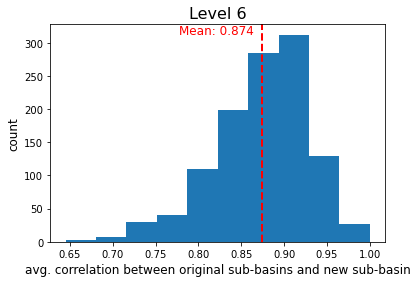

In [24]:
mean_value = weighted_avg_correlations_no_nan.mean()
plt.hist(weighted_avg_correlations_no_nan)
plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label='Mean')
# Add text label for the mean value
plt.text(mean_value-0.01, plt.ylim()[1], f'Mean: {mean_value:.3f}', color='red', fontsize=12, ha='right', va='top')

plt.title("Level 6", fontsize = 16)
plt.xlabel('avg. correlation between original sub-basins and new sub-basin', fontsize=12)
plt.ylabel('count', fontsize=12)

In [14]:
count = 0
for index, row in df_lvl6.iterrows():
    count = count + len(row["SUBIDs"].split(","))

print(count)

57894
